In [66]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
class Value():
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.label = label
        
    def __repr__(self):
        return "Value(data={}, grad={})".format(self.data, self.grad)
    
    def __add__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(other.data + self.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __rsub__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(other.data - self.data, (self, other), '-')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(other.data * self.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ) , "tanh")
        
        def _backward():
            self.grad += 1 - (out.data ** 2)
        out._backward = _backward
        
        return out
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [101]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [130]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2= Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 * x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [131]:
o.grad = 1

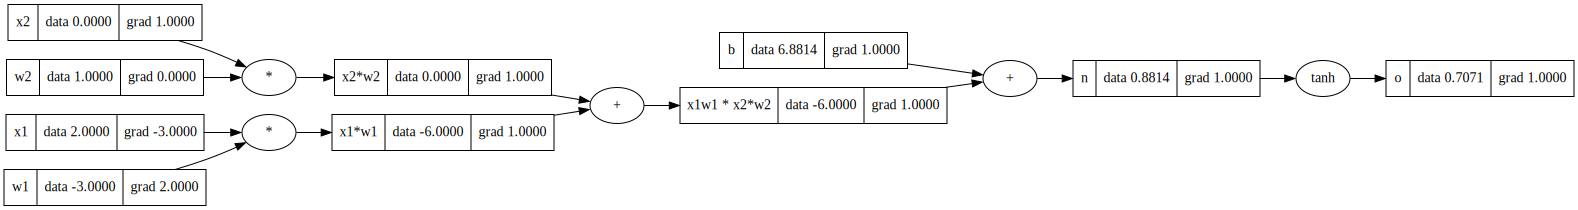

In [135]:
draw_dot(o)

In [134]:
o.backward()